# 0. Import Library

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import src.util as util
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# 1.Load Config

In [3]:
config_data = util.load_config()

# 2. Load Dataset

In [4]:
def load_dataset(config_data: dict) -> pd.DataFrame:
    # Load every set of data
    x_train = util.pickle_load(config_data["train_set_path"][0])
    y_train = util.pickle_load(config_data["train_set_path"][1])

    x_valid = util.pickle_load(config_data["valid_set_path"][0])
    y_valid = util.pickle_load(config_data["valid_set_path"][1])

    x_test = util.pickle_load(config_data["test_set_path"][0])
    y_test = util.pickle_load(config_data["test_set_path"][1])

    # Concatenate x and y each set
    train_set = pd.concat([x_train, y_train], axis = 1)
    valid_set = pd.concat([x_valid, y_valid], axis = 1)
    test_set = pd.concat([x_test, y_test], axis = 1)

    # Return 3 set of data
    return train_set, valid_set, test_set

In [5]:
train_set, valid_set, test_set = load_dataset(config_data)

# 3. Convert Pdays to Pdays Group

In [6]:
def convertPdaysGroup(df):
    """
    Fungsi untuk mengubah nilai pdays menjadi pdays_group
    Parameter:
    - df <pandas dataframe> : dataframe
    
    return:
    - df <pandas dataframe> : dataframe setelah konversi pdays_group
    """
    #mengelompokkan
    bins = [0, 7, 14, 30]
    labels = ['1w', '2w', '2wmore']
    df['pdays_group'] = pd.cut(df['pdays'], bins=bins, labels=labels, include_lowest=False)
    df['pdays_group'] = df['pdays_group'].astype('O')

    # fillna as Not contacted
    df['pdays_group'].fillna('Not contacted', inplace=True)
    df['pdays_group'].value_counts()
    df.drop(columns=['pdays'], axis=1, inplace=True)
    
    return df

In [7]:
train_set = convertPdaysGroup(train_set)
train_set['pdays_group'].value_counts()

Not contacted    27758
1w                 817
2w                 200
2wmore              48
Name: pdays_group, dtype: int64

In [8]:
valid_set = convertPdaysGroup(valid_set)
valid_set['pdays_group'].value_counts()

Not contacted    5961
1w                175
2w                 31
2wmore              9
Name: pdays_group, dtype: int64

In [9]:
test_set = convertPdaysGroup(test_set)
test_set['pdays_group'].value_counts()

Not contacted    5957
1w                170
2w                 45
2wmore              5
Name: pdays_group, dtype: int64

# 4. Convert Age to Age Group

In [10]:
def convertAgeGroup(df): 
    """
    Fungsi untuk mengubah nilai age menjadi age_group
    Parameter:
    - df <pandas dataframe> : dataframe
    
    return:
    - df <pandas dataframe> : dataframe setelah dikelompokkan menjadi age_group
    """
    #membagi age menjadi bin
    bins = [16, 30, 40, 50, 60, 100]
    labels = ['30less', '31-40', '41-50', '51-60', '60more']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)
    #hapus kolom age eksisting
    df.drop(columns=['age'], axis=1, inplace=True)
    return df

In [11]:
train_set = convertAgeGroup(train_set)
train_set['age_group'].value_counts()

31-40     11428
41-50      7209
30less     5214
51-60      4330
60more      642
Name: age_group, dtype: int64

In [12]:
valid_set = convertAgeGroup(valid_set)
valid_set['age_group'].value_counts()

31-40     2490
41-50     1528
30less    1028
51-60      975
60more     155
Name: age_group, dtype: int64

In [13]:
test_set = convertAgeGroup(test_set)
test_set['age_group'].value_counts()

31-40     2462
41-50     1500
30less    1139
51-60      964
60more     112
Name: age_group, dtype: int64

# 5. Encoding Categorical Data

In [14]:
def cat_ohe_fit(config_data):
    for cat in config_data['predictors_categorical']:
        ohe_obj = OneHotEncoder(sparse = False,handle_unknown = 'ignore')
        # Fit ohe
        ohe_obj.fit(np.array(config_data["range_"+cat]).reshape(-1, 1))
        # Save ohe object
        util.pickle_dump(ohe_obj, config_data["ohe_"+cat+"_path"])

In [15]:
cat_ohe_fit(config_data)

In [16]:
def ohe_transform(set_data: pd.DataFrame, tranformed_column: str, ohe_path: str) -> pd.DataFrame:
    # Create copy of set data
    set_data = set_data.copy()

    # Load ohe stasiun
    ohe_obj = util.pickle_load(ohe_path)

    # Transform variable of set data, resulting array
    features = ohe_obj.transform(np.array(set_data[tranformed_column].to_list()).reshape(-1, 1))

    # Convert to dataframe
    column_name = [tranformed_column+"_"+s for s in ohe_obj.categories_[0]]
    features = pd.DataFrame(features.tolist(), columns = list(column_name))

    # Set index by original set data index
    features.set_index(set_data.index, inplace = True)

    # Concatenate new features with original set data
    set_data = pd.concat([features, set_data], axis = 1)

    # Drop stasiun column
    set_data.drop(columns = tranformed_column, inplace = True)

    # Convert columns type to string
    new_col = [str(col_name) for col_name in set_data.columns.to_list()]
    set_data.columns = new_col

    # Return new feature engineered set data
    return set_data

In [17]:
def cat_ohe_transform(set_data, config_data):
    set_data = set_data.copy()
    for cat in config_data['predictors_categorical']:
        set_data = ohe_transform(set_data,cat,config_data["ohe_"+cat+"_path"])
    return set_data

In [18]:
train_set = cat_ohe_transform(train_set,config_data)
train_set

,age_group_30less,age_group_31-40,age_group_41-50,age_group_51-60,age_group_60more,pdays_group_1w,pdays_group_2w,pdays_group_2wmore,pdays_group_Not contacted,poutcome_failure,...,job_unknown,duration,campaign,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y
27506,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,41,2,0,-0.1,93.200,-42.0,4.021,5195.8,no
20991,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,145,1,0,1.4,93.444,-36.1,4.964,5228.1,no
34380,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,451,1,1,-1.8,92.893,-46.2,1.266,5099.1,no
17259,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,124,2,0,1.4,93.918,-42.7,4.962,5228.1,no
15329,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,85,2,0,1.4,93.918,-42.7,4.957,5228.1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6971,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,619,1,0,1.1,93.994,-36.4,4.860,5191.0,no
8970,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,49,1,0,1.4,94.465,-41.8,4.866,5228.1,no
33752,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,585,1,0,-1.8,92.893,-46.2,1.281,5099.1,yes
18503,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,61,1,0,1.4,93.918,-42.7,4.968,5228.1,no


In [19]:
valid_set = cat_ohe_transform(valid_set,config_data)
valid_set

,age_group_30less,age_group_31-40,age_group_41-50,age_group_51-60,age_group_60more,pdays_group_1w,pdays_group_2w,pdays_group_2wmore,pdays_group_Not contacted,poutcome_failure,...,job_unknown,duration,campaign,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y
32348,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,656,1,0,-1.8,92.893,-46.2,1.313,5099.1,yes
13960,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,228,2,0,1.4,93.918,-42.7,4.963,5228.1,no
12169,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,55,1,0,1.4,93.918,-42.7,4.955,5228.1,no
9540,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,168,1,0,1.4,94.465,-41.8,4.961,5228.1,no
16046,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,66,1,0,1.4,93.918,-42.7,4.961,5228.1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,270,1,0,1.1,93.994,-36.4,4.857,5191.0,no
32804,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,234,1,1,-1.8,92.893,-46.2,1.299,5099.1,no
21986,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,70,2,0,1.4,93.444,-36.1,4.964,5228.1,no
39287,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,261,1,0,-1.8,93.369,-34.8,0.646,5008.7,yes


In [20]:
test_set = cat_ohe_transform(test_set,config_data)
test_set

,age_group_30less,age_group_31-40,age_group_41-50,age_group_51-60,age_group_60more,pdays_group_1w,pdays_group_2w,pdays_group_2wmore,pdays_group_Not contacted,poutcome_failure,...,job_unknown,duration,campaign,previous,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y
8123,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,90,4,0,1.4,94.465,-41.8,4.865,5228.1,no
29254,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,232,2,0,-1.8,93.075,-47.1,1.405,5099.1,no
2489,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,104,2,0,1.1,93.994,-36.4,4.856,5191.0,no
23651,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,66,8,0,1.4,93.444,-36.1,4.962,5228.1,no
17776,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,97,1,0,1.4,93.918,-42.7,4.961,5228.1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27461,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,103,2,0,-0.1,93.200,-42.0,4.021,5195.8,no
10592,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,174,2,0,1.4,94.465,-41.8,4.961,5228.1,no
27007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,10,5,0,-0.1,93.200,-42.0,4.021,5195.8,no
21619,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,181,3,0,1.4,93.444,-36.1,4.963,5228.1,no


# 7. Balancing Data

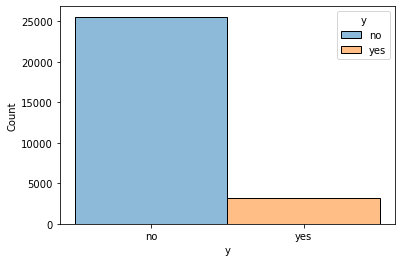

In [21]:
sns.histplot(data = train_set, x = "y", hue = "y")
plt.show()

## 7.1. Undersampling

In [22]:
def rus_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    # Create copy of set data
    set_data = set_data.copy()

    # Create sampling object
    rus = RandomUnderSampler(random_state = 26)

    # Balancing set data
    x_rus, y_rus = rus.fit_resample(set_data.drop("y", axis = 1), set_data['y'])

    # Concatenate balanced data
    set_data_rus = pd.concat([x_rus, y_rus], axis = 1)

    # Return balanced data
    return set_data_rus

In [23]:
train_set_rus = rus_fit_resample(train_set)

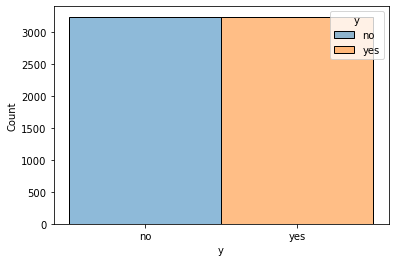

In [24]:
sns.histplot(train_set_rus, x = "y", hue = "y")
plt.show()

## 7.2. Oversampling

In [25]:
def ros_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    # Create copy of set data
    set_data = set_data.copy()

    # Create sampling object
    ros = RandomOverSampler(random_state = 11)

    # Balancing set data
    x_ros, y_ros = ros.fit_resample(set_data.drop("y", axis = 1), set_data["y"])

    # Concatenate balanced data
    set_data_ros = pd.concat([x_ros, y_ros], axis = 1)

    # Return balanced data
    return set_data_ros

In [26]:
train_set_ros = ros_fit_resample(train_set)

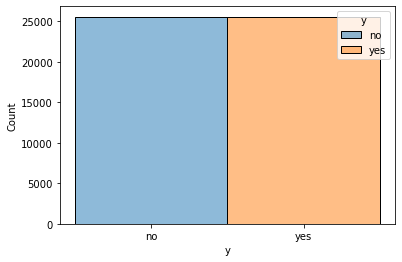

In [27]:
sns.histplot(train_set_ros, x = "y", hue = "y")
plt.show()

## 7.3. SMOTE

In [28]:
def sm_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    # Create copy of set data
    set_data = set_data.copy()

    # Create sampling object
    sm = SMOTE(random_state = 112)

    # Balancing set data
    x_sm, y_sm = sm.fit_resample(set_data.drop("y", axis = 1), set_data["y"])

    # Concatenate balanced data
    set_data_sm = pd.concat([x_sm, y_sm], axis = 1)

    # Return balanced data
    return set_data_sm

In [29]:
train_set_sm = sm_fit_resample(train_set)

<AxesSubplot:xlabel='y', ylabel='Count'>

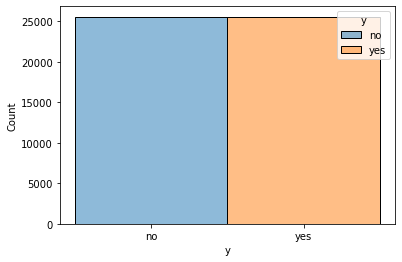

In [30]:
sns.histplot(train_set_sm, x = "y", hue = "y")

# 8. Label Encoder

## 8.1. Fit LE to Label Data

In [31]:
def le_fit(data_tobe_fitted: dict, le_path: str) -> LabelEncoder:
    # Create le object
    le_encoder = LabelEncoder()

    # Fit le
    le_encoder.fit(data_tobe_fitted)

    # Save le object
    util.pickle_dump(le_encoder, le_path)

    # Return trained le
    return le_encoder

In [32]:
le_encoder = le_fit(config_data["label_categories"], config_data["le_path"])

In [33]:
def le_transform(label_data: pd.Series, config_data: dict) -> pd.Series:
    # Create copy of label_data
    label_data = label_data.copy()

    # Load le encoder
    le_encoder = util.pickle_load(config_data["le_path"])

    # If categories both label data and trained le matched
    if len(set(label_data.unique()) - set(le_encoder.classes_) | set(le_encoder.classes_) - set(label_data.unique())) == 0:
        # Transform label data
        label_data = le_encoder.transform(label_data)
    else:
        raise RuntimeError("Check category in label data and label encoder.")
    
    # Return transformed label data
    return label_data

In [34]:
train_set_rus.y = le_transform(train_set_rus.y, config_data)
train_set_rus.y

0       0
1       0
2       0
3       0
4       0
       ..
6489    1
6490    1
6491    1
6492    1
6493    1
Name: y, Length: 6494, dtype: int32

In [35]:
train_set_ros.y = le_transform(train_set_ros.y, config_data)

In [36]:
train_set_sm.y = le_transform(train_set_sm.y, config_data)

In [37]:
valid_set.y = le_transform(valid_set.y, config_data)

In [38]:
test_set.y = le_transform(test_set.y, config_data)

In [39]:
x_train = {
    "Undersampling" : train_set_rus.drop(columns = "y"),
    "Oversampling" : train_set_ros.drop(columns = "y"),
    "SMOTE" : train_set_sm.drop(columns = "y")
}

y_train = {
    "Undersampling" : train_set_rus.y,
    "Oversampling" : train_set_ros.y,
    "SMOTE" : train_set_sm.y
}

In [40]:
util.pickle_dump(x_train, "data/processed/x_train_feng.pkl")
util.pickle_dump(y_train, "data/processed/y_train_feng.pkl")

util.pickle_dump(valid_set.drop(columns = "y"), "data/processed/x_valid_feng.pkl")
util.pickle_dump(valid_set.y, "data/processed/y_valid_feng.pkl")

util.pickle_dump(test_set.drop(columns = "y"), "data/processed/x_test_feng.pkl")
util.pickle_dump(test_set.y, "data/processed/y_test_feng.pkl")